# Import the libaries

In [1]:
from selenium.webdriver.common.by import By
import time
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, TextVectorization, GRU
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint, CSVLogger
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import StandardScaler
warnings.simplefilter(action='ignore', category=FutureWarning)
from scipy import stats

# Scraping the data

Membuka browser untuk keperluan scraping

In [3]:
chrome_driver_path = "chromedriver.exe"
options = Options()
driver = webdriver.Chrome(options=options)
driver.get("https://twitter.com/")

## Get tweets data

Mengambil list data tweet yang iambil dari serach tab. Search query pada kasus ini adalah IKN

In [4]:
data={
    'articles': []
}
articles  = driver.find_elements(By.TAG_NAME, "article")
data['articles']= data['articles']+[a.text for a in articles]
for i in range(15):
    articles  = driver.find_elements(By.TAG_NAME, "article")
    data['articles']= data['articles']+[a.text for a in articles]
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(5) 

Melakukan parsing data mentah menjadi 3 kolom, yaitu username, user id dan tweet

In [5]:
# initial data untuk pandas
tweet_parsing={'username':[],
               'user_id':[],
               'tweet': []
}
no_detect=[]
for tweet in data['articles']:
    teks = tweet
    pola = r"(?P<username>[\w\s]+)\n(?P<userid>@[\w]+)\n·\n[\w]+\n(?P<tweet>[\s\S]*)\n\d+" # pola yang digunakan untuk mendeteksi username dan user id
    cocokan = re.search(pola, teks) # proses mencocokan dengan pola menggunakan regex
    if cocokan:
        username = cocokan.group('username')
        userid = cocokan.group('userid')
        tweet = cocokan.group('tweet')
        tweet_parsing['user_id'].append(userid)
        tweet_parsing['username'].append(username)
        tweet_parsing['tweet'].append(tweet)
    else:
        no_detect.append(teks)


Mengconvert data menjadi pandas agar mudah dikelola

In [ ]:
tweet_df = pd.DataFrame(tweet_parsing).drop_duplicates()
tweet_df.drop_duplicates(inplace=True)

menyimpan data di file csv untuk diakses dikemudian hari

In [ ]:
tweet_df.to_csv('tweet.csv', index=False)

In [63]:
tweet_df=pd.read_csv('tweet.csv')

# Get Profile Data

In [ ]:
profil={
    'user_id': [],
    'join': [],
    'followers':[],
    'following':[]
}
i =0
for user_id in tweet_df['user_id'].unique():
    i+=1
    print(i)
    try:
        driver.get(f'https://twitter.com/{user_id[1:]}') # mengakses profil pengguna tweeter menggunakan link
        join = WebDriverWait(driver, 10).until(
            EC.visibility_of_element_located((By.CSS_SELECTOR,'[data-testid="UserProfileHeader_Items"]')) # mengambil data deskripsi
        ) # menunggu sampai element yang diharapkan muncul
        join=join.text
        tmp = driver.find_elements(By.TAG_NAME, "a") # mencari semua link yang ada pada halaman
        url = [i.get_attribute("Href") for i in tmp]
        idx= url.index(f'https://twitter.com/{user_id[1:]}/following') # mencari element jumlah following
        followers = tmp[idx+1].text
        following = tmp[idx].text
        profil['user_id'].append(user_id[1:])
        profil['join'].append(join)
        profil['followers'].append(followers)
        profil['following'].append(following)
        time.sleep(4) # menambahan jeda waktu agar terhindar dari dugaan brute force
    except:
        print(user_id)


In [12]:
profil_df = pd.DataFrame(profil) # merubah data menjadi pandas agar mudah dikelola

In [ ]:
profil_df.to_csv('profil.csv', index=False) # menyimoan data di csv file untuk diakses dikemudian hari

In [104]:
profil_df = pd.read_csv('profil.csv')
profil_df[['description', 'join']]=profil_df['join'].str.split('Joined', expand=True) # memisahkan data deskripsi dan data tanggal join
profil_df['followers'] = profil_df['followers'].str.replace(' Followers', '') # menghapus tulisan follower
profil_df['following'] = profil_df['following'].str.replace(' Following', '') # menghapus tulisan following
profil_df['followers'] = profil_df['followers'].str.replace(',', '') # menghapus tanda koma
profil_df['following'] = profil_df['following'].str.replace(',', '') # menghapus tanda koma
profil_df['followers'] = profil_df['followers'].str.replace('K', '*1000').str.replace('M', '*1000000').map(pd.eval) # mengganti k dengan 100 dan m menjadi 1000000
profil_df['following'] = profil_df['following'].str.replace('K', '*1000').str.replace('M', '*1000000').map(pd.eval) # mengganti k dengan 100 dan m menjadi 1000000
profil_df['join'] = pd.to_datetime(profil_df['join'], format=' %B %Y') # merubah format text menjadi date

In [108]:
tweet_df['user_id'] = tweet_df['user_id'].str.replace('@', '')

In [106]:
merged_data = profil_df.merge(tweet_df, left_on='user_id', right_on='user_id', how='right').drop_duplicates()

In [107]:
merged_data.head()

,user_id,join,followers,following,description,feature,sentimen,negativity
0,AbdullahArdhi,2023-04-01,117.0,214.0,Slawi,kolaborasi ikn acwa power sinergi kehidupan hi...,negatif,0.998675
1,bewithyiu,2021-05-01,742.0,743.0,Rumah Singgah Eunoia secreto.site/agno21,uang pajak dialokasikan berguna bangun patung ...,negatif,0.998542
2,wientaxa,2024-03-01,3.0,111.0,Indonesia Bagian Marjinal,ikn sekedar perwujudan ambisi politik nafsu me...,negatif,0.998881
3,wibungitis,2020-05-01,90.0,239.0,rentry.co/sai55,they 're building ikn like township kumparan m...,negatif,0.998115
4,avocado_juice41,2023-09-01,26.0,60.0,,ikn menelan biaya yg fantastis udah gitu urgen...,negatif,0.998780


# Modeling

Model dibuat dengan menggunakan deep learning berbasis RNN krena RNN memiliki kemampuan untuk memperhitungkan data secara urutan. Dataset merupakan data yang diambil dari public di [github](https://github.com/syenirasheila/Sentiment-Analysis-IKN-Using-SVM-QE/blob/main/Dataset/Sentimen_Pengguna_Twitter_Pada_Topik_IKN.csv)

Selain membutuhkan dataset, stopwords juga diperlukan untuk membuang kata-kata yang tiak perlu diperhitungkan dalam menilai sentimen. Kata-lata ini dapat berupa kata sambung, kata imbuhan, tempat dan lai sebagainya

In [6]:
def add_stopwords(file_path, stopword_list):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopword_baru = [stopword.strip() for stopword in file.readlines()]
        stopword_list.extend(stopword_baru)
stop_words=['rt', 're', 'xe2', 'x80', 'xa6', '200', 'b20']
add_stopwords('id.stopwords.02.01.2016.txt', stop_words)
add_stopwords('stopwords-id.txt', stop_words)

## Exploratory Data Analysis dataset 

**Jumlah data berdasarkan sentiment**

In [8]:
data = pd.read_csv('Sentimen_Pengguna_Twitter_Pada_Topik_IKN.csv', delimiter=";")

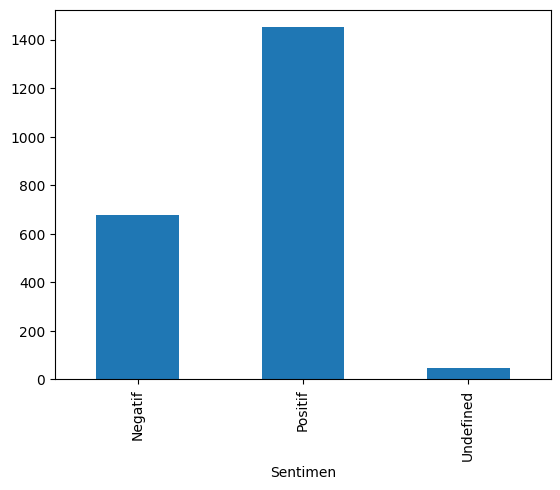

In [9]:
data_eda = data.copy()
data_eda.groupby('Sentimen')['Sentimen'].count().plot(kind='bar')
plt.show()

Dataset lebih banyak memiliki dataset positif dibandingan dengan data negatif

**Sebaran Jumlah kata pada setiap sentiment**

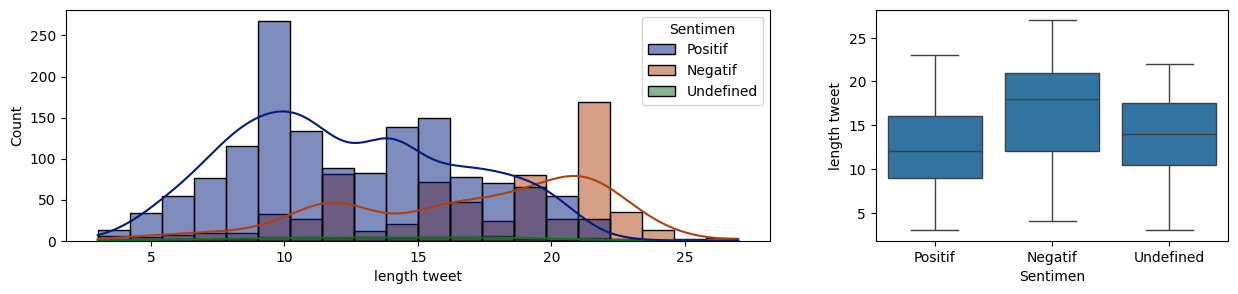

In [10]:
data_eda['length tweet']=data_eda['Tweet'].str.count(' ') + 1
fig, ax=plt.subplots(1,2 , figsize=[15,3], gridspec_kw={'width_ratios': [2, 1]})
sns.histplot(data=data_eda, x = 'length tweet', hue='Sentimen', kde=True, palette='dark', ax =ax[0])
sns.boxplot(data_eda, x='Sentimen', y ='length tweet', ax=ax[1])
plt.show()

Sebaran jumlah kata berdasarkan sentimen menunjukkan bahwa tweet dengan sentiment postif cenderung memilik jumlah kata lebih banyak dibandingkan tweet negatif. Untuk menguji signifikansinya, kita isa menggunakan **TTEST Indepent sampel**

In [11]:
_, p = stats.ttest_ind(data_eda[data_eda['Sentimen']=='Positif']['length tweet'],
                data_eda[data_eda['Sentimen']=='Negatif']['length tweet'])
if p>0.05:
    print('Panjang kalimat tweet negatif dan positif tidak memiliki perbedaan yang signifikan')
else:
    print(f'Panjang kalimat tweet positif dan negatif memiliki perbedan yang signifikan yang dibuktikan dengan nilai p value senilai {p:.2e}')

Panjang kalimat tweet positif dan negatif memiliki perbedan yang signifikan yang dibuktikan dengan nilai p value senilai 6.84e-99


In [12]:
def preprocessing_text(texts):
  texts = texts.lower() #make it lowercase
  texts = re.sub("@[a-z0-9_.]+"," ", texts) # Remove words starting with @
  texts = re.sub("x[a-z0-9_.]+"," ", texts) # Remove words starting with @
  texts = re.sub("replying to"," ", texts)
  texts = re.sub(r"http\S+", " ", texts) #remove link
  texts = re.sub(r"https\S+", " ", texts) #remove link
  texts = re.sub(r"www.\S+", " ", texts) #remove link
  tokens = word_tokenize(texts) # tokeenize
  texts = ' '.join([word for word in tokens if word not in stop_words]) #remove stop word
  texts = re.sub(r"#", "", texts)
  return texts
data_eda['text clean']=data_eda['Tweet'].apply(lambda x: preprocessing_text(x)) #cleaning word process

Before using the word cloud, I first carried out tf-idf data with the hope that the words that appeared were only important words.

In [13]:
# create a function to create a word cloud via tf idf.
vectorize=TfidfVectorizer() #TFIDF initializer
vectorize.fit_transform(data_eda['text clean'])
def plot_word(data, color = 'black', figsize=(7, 7), max_words=75):
    teks=vectorize.fit_transform(data)
    feature_names = vectorize.get_feature_names_out()
    dense = teks.todense()
    lst1 = dense.tolist()
    df = pd.DataFrame(lst1, columns=feature_names)
    wordcloud = WordCloud(stopwords=stop_words, # delete stopword
                      background_color=color,
                      width=1200,
                      height=800,
                      max_words=max_words,
                     ).generate_from_frequencies(df.T.sum(axis=1))
    plt.figure(1,figsize=figsize)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

## Kata sering muncul

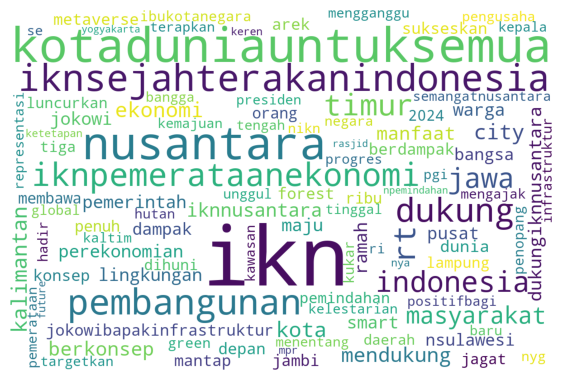

In [14]:
#show wordcloud sentimen positif
plot_word(data_eda[data_eda.Sentimen=='Positif']['text clean'].dropna(), 'white', max_words=100)

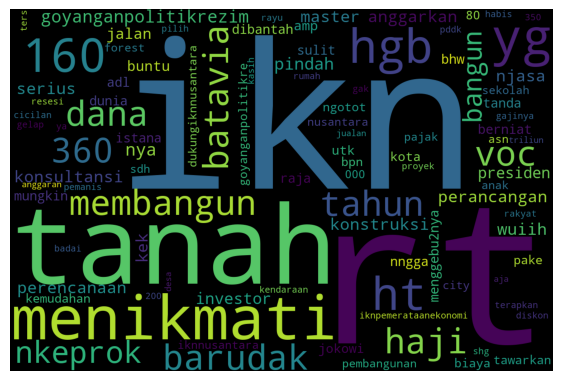

In [15]:
#show wordcloud sentimen negatif
plot_word(data_eda[data_eda.Sentimen=='Negatif']['text clean'], 'black', max_words=100)

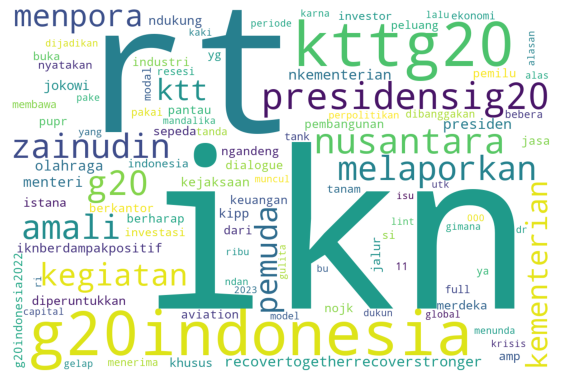

In [16]:
#show wordcloud sentimen netral
plot_word(data_eda[data_eda.Sentimen=='Undefined']['text clean'], 'white', max_words=100)

## Preprocessing

In [62]:
max_feature=0
#membuat fungsi untuk case folding
def preprocessing_text(texts):
  global max_feature
  texts = texts.lower() #lowering text
  texts = texts.strip()
  texts = re.sub("@[a-z0-9_.]+"," ", texts) # Menghapus kata yang dimulai dengan @
  texts = re.sub("replying to"," ", texts)
  texts = re.sub(r"\\n"," ",texts) #menghapus enter text
  texts = re.sub(r"http\S+", " ", texts) #menghapus link
  texts = re.sub(r"www.\S+", " ", texts) #menghapus link
  texts = re.sub("[^a-z\s']"," ", texts) # menghapus selain alfabet
  tokens = word_tokenize(texts) # tokeenize
  if len(tokens)>max_feature:max_feature=len(tokens) # menghitung kata dengan jumlah kata terbanyak.
  texts = ' '.join([word for word in tokens if word not in stop_words]) #menghapus stop word
  return texts

## Membuat feature dan target untuk model

In [18]:
data['feature']=data['Tweet'].apply(lambda x: preprocessing_text(x))

In [19]:
data['label'] = data['Sentimen'].replace({'Positif' : 2, 'Undefined':1, 'Negatif' : 0}) #label diambil dari data sentimen. Data diubah jadi 0,1 dan 2 agar lebih mudah di convert menggunakan one hot encoder

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data.feature, data.label, test_size=0.2, random_state=0, stratify=data.label) # membagi dat menjadi train dan test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0) #membagi data test menjadi test dan validation data

In [21]:
#encoding target
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)
y_val_ohe = to_categorical(y_val)

## Text Vectorizing

In [22]:
#Hitung jumlah cocab
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
jml_vocab = len(Vectorize.vocabulary_.keys())
print('jumlah vocab adalah sebanyak '+str(jml_vocab))

jumlah vocab adalah sebanyak 1635


## Intializing Model

In [194]:
text_vectorization = TextVectorization(max_tokens=jml_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_feature,
                                       input_shape=(1,)
                                       )

text_vectorization.adapt(X_train)

#### LSTM Model

In [195]:
embedding = Embedding(input_dim=jml_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=jml_vocab
                      )
model_lstm_1st = Sequential()
model_lstm_1st.add(text_vectorization)
model_lstm_1st.add(embedding)
model_lstm_1st.add(LSTM(max_feature))
model_lstm_1st.add(Dense(3,activation='softmax'))

model_lstm_1st.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_lstm_1st.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 142)               0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 142, 128)          209280    
                                                                 
 lstm_1 (LSTM)               (None, 142)               153928    
                                                                 
 dense_2 (Dense)             (None, 3)                 429       
                                                                 
Total params: 363637 (1.39 MB)
Trainable params: 363637 (1.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


#### GRU Model

In [196]:
embedding = Embedding(input_dim=jml_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=jml_vocab
                      )
model_gru_1st = Sequential()
model_gru_1st.add(text_vectorization)
model_gru_1st.add(embedding)
model_gru_1st.add(GRU(max_feature))
model_gru_1st.add(Dense(3,activation='softmax'))
model_gru_1st.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model_gru_1st.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_1 (Text  (None, 142)               0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 142, 128)          209280    
                                                                 
 gru_1 (GRU)                 (None, 142)               115872    
                                                                 
 dense_3 (Dense)             (None, 3)                 429       
                                                                 
Total params: 325581 (1.24 MB)
Trainable params: 325581 (1.24 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


## Train Model

### LSTM Model

In [197]:
csv_logger = CSVLogger('hist_lstm_1st.log')
model_checkpoint_callback = ModelCheckpoint(
    filepath='model/lstm_1st',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist_lstm_1st = model_lstm_1st.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         batch_size=16,
                         callbacks=[csv_logger, model_checkpoint_callback],
                         validation_data=(X_test, y_test_ohe))

Epoch 1/50


87/87 [==============================] - 9s 97ms/step - loss: 0.7510 - accuracy: 0.6595 - val_loss: 0.7185 - val_accuracy: 0.6674
Epoch 2/50
87/87 [==============================] - 9s 99ms/step - loss: 0.7598 - accuracy: 0.6616 - val_loss: 0.7482 - val_accuracy: 0.6674
Epoch 3/50
87/87 [==============================] - 8s 95ms/step - loss: 0.7490 - accuracy: 0.6530 - val_loss: 0.7175 - val_accuracy: 0.6674
Epoch 4/50
87/87 [==============================] - 8s 95ms/step - loss: 0.7325 - accuracy: 0.6595 - val_loss: 0.7145 - val_accuracy: 0.6674
Epoch 5/50
87/87 [==============================] - 8s 96ms/step - loss: 0.7257 - accuracy: 0.6667 - val_loss: 0.7183 - val_accuracy: 0.6674
Epoch 6/50
87/87 [==============================] - 8s 97ms/step - loss: 0.7275 - accuracy: 0.6667 - val_loss: 0.7160 - val_accuracy: 0.6674
Epoch 7/50
87/87 [==============================] - 8s 97ms/step - loss: 0.7226 - accuracy: 0.6667 - val_loss: 0.7438 - val_accuracy: 0.6674
Epoch 8/50
87/87 [======

<Axes: >

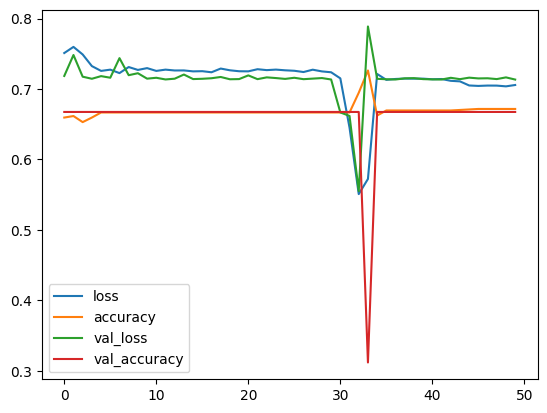

In [198]:
metrics = pd.DataFrame(hist_lstm_1st.history)
metrics.plot()

### GRU Model

In [199]:
csv_logger = CSVLogger('hist_gru_1st.log')
model_checkpoint_callback = ModelCheckpoint(
    filepath='model/gru_1st',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

hist_gru_1st = model_gru_1st.fit(X_train,
                         y_train_ohe,
                         epochs=50,
                         batch_size=16,
                         callbacks=[csv_logger, model_checkpoint_callback],
                         validation_data=(X_test, y_test_ohe))

Epoch 1/50
87/87 [==============================] - 8s 83ms/step - loss: 0.7628 - accuracy: 0.6667 - val_loss: 0.7170 - val_accuracy: 0.6674
Epoch 2/50
87/87 [==============================] - 7s 81ms/step - loss: 0.7281 - accuracy: 0.6667 - val_loss: 0.7146 - val_accuracy: 0.6674
Epoch 3/50
87/87 [==============================] - 7s 80ms/step - loss: 0.7201 - accuracy: 0.6667 - val_loss: 0.7190 - val_accuracy: 0.6674
Epoch 4/50
87/87 [==============================] - 7s 81ms/step - loss: 0.7140 - accuracy: 0.6703 - val_loss: 0.7280 - val_accuracy: 0.6674
Epoch 5/50
87/87 [==============================] - 7s 80ms/step - loss: 0.7249 - accuracy: 0.6667 - val_loss: 0.7166 - val_accuracy: 0.6674
Epoch 6/50
87/87 [==============================] - 7s 82ms/step - loss: 0.7241 - accuracy: 0.6667 - val_loss: 0.7172 - val_accuracy: 0.6674
Epoch 7/50
87/87 [==============================] - 7s 81ms/step - loss: 0.7187 - accuracy: 0.6688 - val_loss: 0.7163 - val_accuracy: 0.6674
Epoch 8/50
87

<Axes: >

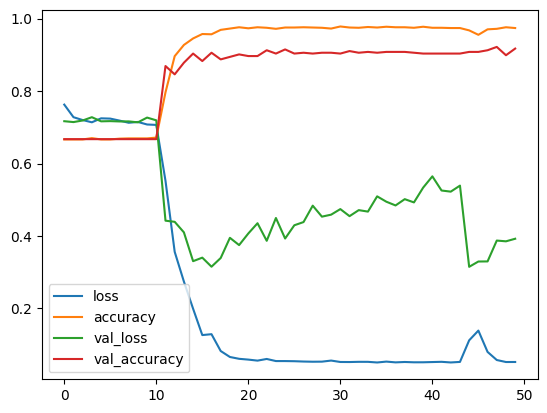

In [200]:
pd.DataFrame(hist_gru_1st.history).plot()

## Model Evaluation

### LSTM

In [312]:
pred_train=model_lstm_1st.predict(X_train)
pred_test=model_lstm_1st.predict(X_test)
pred_train_lbl=pred_train.argmax(axis=1)
pred_test_lbl=pred_test.argmax(axis=1)

14/14 [==============================] - 0s 34ms/step


In [313]:
print(classification_report(y_train, pred_train_lbl))
print(classification_report(y_test, pred_test_lbl))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       431
           1       1.00      0.21      0.35        33
           2       0.67      1.00      0.80       928

    accuracy                           0.67      1392
   macro avg       0.56      0.40      0.38      1392
weighted avg       0.47      0.67      0.54      1392

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       136
           1       0.00      0.00      0.00         9
           2       0.67      1.00      0.80       291

    accuracy                           0.67       436
   macro avg       0.22      0.33      0.27       436
weighted avg       0.45      0.67      0.53       436



/Users/wahyudiwahyudi/anaconda3/envs/portofolio/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wahyudiwahyudi/anaconda3/envs/portofolio/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/wahyudiwahyudi/anaconda3/envs/portofolio/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Model masih mengalami over-fit karena hasil train sangat tinggi sedangkan test sangat rendah

### GRU

In [210]:
pred_train=model_gru_1st.predict(X_train)
pred_test=model_gru_1st.predict(X_test)
pred_train_lbl=pred_train.argmax(axis=1)
pred_test_lbl=pred_test.argmax(axis=1)

14/14 [==============================] - 0s 24ms/step


In [211]:
print(classification_report(y_train, pred_train_lbl))
print(classification_report(y_test, pred_test_lbl))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96       431
           1       1.00      1.00      1.00        33
           2       0.98      0.98      0.98       928

    accuracy                           0.98      1392
   macro avg       0.98      0.98      0.98      1392
weighted avg       0.98      0.98      0.98      1392

              precision    recall  f1-score   support

           0       0.86      0.91      0.89       136
           1       0.50      0.33      0.40         9
           2       0.95      0.94      0.95       291

    accuracy                           0.92       436
   macro avg       0.77      0.73      0.74       436
weighted avg       0.92      0.92      0.92       436



Model Gru memiliki performa yang lebih baik. odel GRU dapat mengenali sentimen negatif dan positif dengan baik pada data train maupun data test

In [354]:
model_gru_1st.save('model/best_model/gru.tf')

INFO:tensorflow:Assets written to: model/best_model/gru.tf/assets


INFO:tensorflow:Assets written to: model/best_model/gru.tf/assets


In [24]:
from keras.models import load_model
model_gru_1st= load_model('model/best_model/gru.tf')


# Penggunaan pada data tweeter

In [64]:
tweet_df['feature']= tweet_df['tweet'].apply(lambda x: preprocessing_text(x))
tweet_df.drop(columns=['username', 'tweet'], inplace=True)
tweet_df.drop_duplicates(inplace=True)

In [65]:
pred = model_gru_1st.predict(tweet_df['feature'])
sentimen = np.argmax(pred, axis=1)
tweet_df['sentimen'] = sentimen
tweet_df

2/2 [==============================] - 0s 17ms/step


,user_id,feature,sentimen
0,@AbdullahArdhi,kolaborasi ikn acwa power sinergi kehidupan hi...,0
1,@bewithyiu,uang pajak dialokasikan berguna bangun patung ...,0
2,@wientaxa,ikn sekedar perwujudan ambisi politik nafsu me...,0
3,@wibungitis,they 're building ikn like township kumparan m...,0
4,@avocado_juice41,ikn menelan biaya yg fantastis udah gitu urgen...,0
5,@Baggiioooo,mmnita korut untk mngebom ikn dgn nuklirnya,0
7,@tanyarlfes,automated tanyarl sender kepooo tau pandangan ...,0
8,@sinceApril1970,and didn t brucey first spot the talent that i...,0
10,@sweetnaviblue,maen ikn,2
11,@almema_hasnaa,dukungan ikn masyarakat indonesia memiliki sem...,2


In [66]:
tweet_df['sentimen'] = tweet_df['sentimen'].replace({0:'negatif', 1:'unidentify', 2:"positif"})

In [67]:
tweet_df[tweet_df['sentimen']=='positif']

,user_id,feature,sentimen
10,@sweetnaviblue,maen ikn,positif
11,@almema_hasnaa,dukungan ikn masyarakat indonesia memiliki sem...,positif
18,@duniagemoy,ikn setuju akses krl kereta api diperbanyak di...,positif
19,@duniauli,iya orang miskinnya kota ikn,positif
24,@SSiNN_ikn,,positif
30,@cend241,sebenernya gw dukung ikn kalo pemerataan pemba...,positif
32,@deluluww,ikn solusi,positif
34,@macarvns,tuh moms ikn o,positif
41,@ikn_hjl,,positif
42,@liputan6dotcom,pembangunan ikn pasar potensial industri keram...,positif


In [69]:
tweet_df[tweet_df['sentimen']=='negatif']

,user_id,feature,sentimen
0,@AbdullahArdhi,kolaborasi ikn acwa power sinergi kehidupan hi...,negatif
1,@bewithyiu,uang pajak dialokasikan berguna bangun patung ...,negatif
2,@wientaxa,ikn sekedar perwujudan ambisi politik nafsu me...,negatif
3,@wibungitis,they 're building ikn like township kumparan m...,negatif
4,@avocado_juice41,ikn menelan biaya yg fantastis udah gitu urgen...,negatif
5,@Baggiioooo,mmnita korut untk mngebom ikn dgn nuklirnya,negatif
7,@tanyarlfes,automated tanyarl sender kepooo tau pandangan ...,negatif
8,@sinceApril1970,and didn t brucey first spot the talent that i...,negatif
12,@arieindienesia,roma irama ikn lagu mati ikn mahal film pendek,negatif
13,@duniauli,and gue nungguin ikn dijadiin patokan wonderfu...,negatif


In [71]:
tweet_df['negativity'] = model_gru_1st.predict(tweet_df['feature'])[:,0]

2/2 [==============================] - 0s 17ms/step


## Kata yang sering muncul

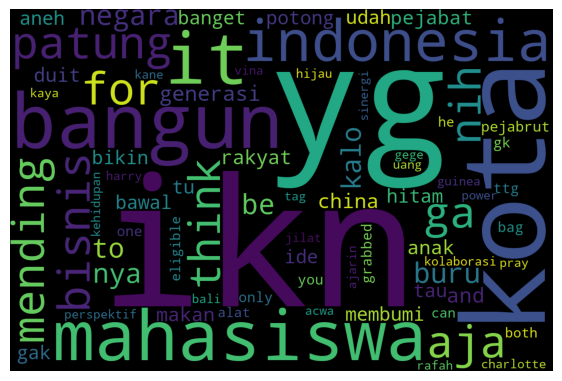

In [ ]:
plot_word(tweet_df[tweet_df['sentimen']=='negatif']['feature'])

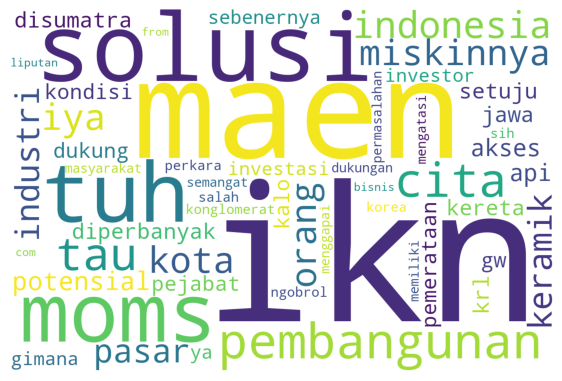

In [ ]:
plot_word(tweet_df[tweet_df['sentimen']=='positif']['feature'], 'white')

# Buzzer analysis

## Analisa kemiripan tweet

In [79]:
from sklearn.metrics.pairwise import cosine_similarity
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(tweet_df['feature'])

# Menghitung cosine similarity antara setiap pasang kalimat
cos_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Menampilkan hasil kemiripan
results = []
for i in range(len(tweet_df['feature'])):
    for j in range(i+1, len(tweet_df['feature'])):
        # print(f"Similarity between kalimat {i+1} and kalimat {j+1}: {cos_sim[i][j]}")
        if i!=j:
            similarity_score = cos_sim[i][j]
            results.append([tweet_df['user_id'].values[i], 
                            tweet_df['feature'].values[i],
                            tweet_df['user_id'].values[j], 
                            tweet_df['feature'].values[j], similarity_score])

similarity = pd.DataFrame(results, columns=["user 1", "Kalimat 1", "user 2", "Kalimat 2", "Cosine Similarity Score"])
similarity.drop_duplicates(inplace=True)
similarity.sort_values('Cosine Similarity Score', ascending=False, inplace=True)
# .to_excel('hapus.xlsx')

In [80]:
similarity.head(10)

,user 1,Kalimat 1,user 2,Kalimat 2,Cosine Similarity Score
24,@AbdullahArdhi,kolaborasi ikn acwa power sinergi kehidupan hi...,@jokowiofc,kolaborasi ikn acwa power sinergi kehidupan hi...,1.000000
137,@wibungitis,they 're building ikn like township kumparan m...,@deviannisaa,menikmati ikn nanggungnya rakyat ga paham ikn ...,0.749821
259,@tanyarlfes,automated tanyarl sender kepooo tau pandangan ...,@stinao_,ya emang boros rumah pejabat ikn dibangun pake...,0.621386
195,@avocado_juice41,ikn menelan biaya yg fantastis udah gitu urgen...,@deikazuya,bangun ikn mendingan duitnya dipake pemerataan...,0.429131
603,@duniauli,iya orang miskinnya kota ikn,@machrilmachril1,menteri wamen orang sore bengong main bola kak...,0.255346
501,@papamekdi,generasi nih yg bangun ikn,@deikazuya,bangun ikn mendingan duitnya dipake pemerataan...,0.252690
185,@avocado_juice41,ikn menelan biaya yg fantastis udah gitu urgen...,@pillowaguilina,ikn mending kota kasih t proyek strategis nega...,0.239483
174,@avocado_juice41,ikn menelan biaya yg fantastis udah gitu urgen...,@papamekdi,generasi nih yg bangun ikn,0.235394
765,@pillowaguilina,ikn mending kota kasih t proyek strategis nega...,@deikazuya,bangun ikn mendingan duitnya dipake pemerataan...,0.212975
943,@GhhopesHi,i think it s ikn,@aaniiindaa,ikn singapore meaning dijajah i m planning to ...,0.199061


Dari data ini dietemukan ada 2 tweet yang memiliki kesamaan twwet yang sangat mirip yaitu berasal dari akun [@AbdullahArdhi](https://twitter.com/AbdullahArdhi) dan [@jokowiofc](https://twitter.com/jokowiofc)

In [93]:
for i in range(3):
    print(f'{i+1}.')
    print(f'{similarity.iloc[i, 1]} \nmirip dengan \n{similarity.iloc[i, 3]}')
    print('\n')
    print('='*50)

1.
kolaborasi ikn acwa power sinergi kehidupan hijau tag indonesia vs guinea mahasiswa wib pray for rafah bali charlotte ajarin wonbin gege harry kane jilat vina zhaolusi 
mirip dengan 
kolaborasi ikn acwa power sinergi kehidupan hijau tag jilat vina indonesia vs guinea mahasiswa wib pray for rafah bali charlotte ajarin wonbin gege harry kane zhaolusi


2.
they 're building ikn like township kumparan may bas patung soekarno hatta api abadi memorial park ikn anggaran rp miliar bisnis update bisnis text 
mirip dengan 
menikmati ikn nanggungnya rakyat ga paham ikn dilanjutkan kumparan may bas patung soekarno hatta api abadi memorial park ikn anggaran rp miliar bisnis update bisnis text


3.
automated tanyarl sender kepooo tau pandangan mahasiswa ttg ikn pls buzz r p l t k dni 
mirip dengan 
ya emang boros rumah pejabat ikn dibangun pake duit negara alias dri pajak harga milyar tanyarlfes m automated tanyarl sender kepooo tau pandangan mahasiswa ttg ikn pls buzz r p l t k dni




In [129]:
buzzer = similarity.iloc[0,[0,2]].tolist()

## Clustering pada jumlah follower dan Berapa lama Join

In [114]:
merged_data['join in days']=(pd.to_datetime('today') - merged_data['join']).dt.days

<Axes: ylabel='join in days'>

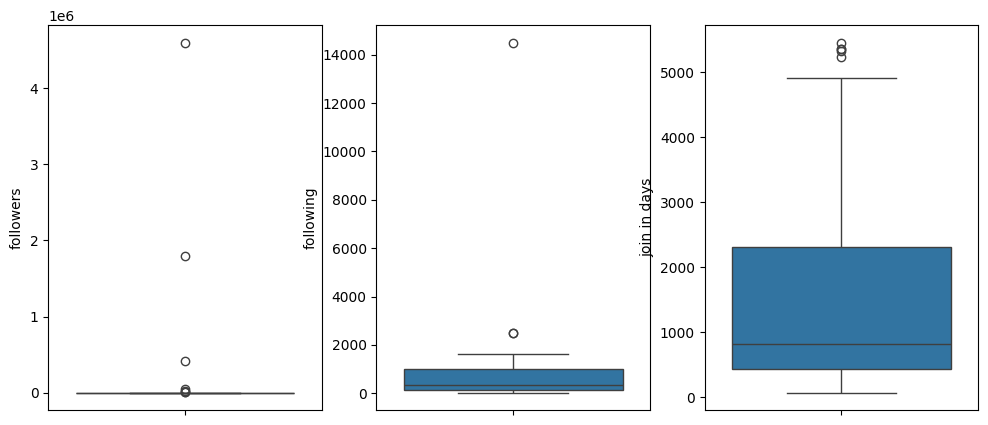

In [115]:
fig, ax = plt.subplots(1,3, figsize=[12,5])
sns.boxplot(merged_data['followers'], ax=ax[0])
sns.boxplot(merged_data['following'], ax=ax[1])
sns.boxplot(merged_data['join in days'], ax=ax[2])

Karena terlalu banyak data outlier, maka perlu di bersihkan menggunakan teknik capping

In [116]:
def caping_outlier(x, mean, iqr):
    min_value = mean - 1.5*iqr
    max_value = mean + 1.5*iqr
    # print(min_value)
    # print(max_value)
    if x< min_value:
        return min_value
    elif x> max_value:
        return max_value
    else:
        return x
def capping_outliers_pandas(data, columns):
    for c in columns:
        iqr = data[c].quantile([0.25, 0.75]).diff()[0.75]
        rata_rata = data[c].median()
        data[c]= data[c].apply(lambda x: caping_outlier(x, rata_rata, iqr))

In [117]:
capping_outliers_pandas(merged_data, ['followers', 'following', 'join in days'])

In [118]:
merged_data.describe().T

,count,mean,min,25%,50%,75%,max,std
join,44,2019-08-13 17:27:16.363636480,2009-06-01 00:00:00,2018-01-15 06:00:00,2022-02-15 00:00:00,2023-03-08 18:00:00,2024-03-01 00:00:00,NaN
followers,44.0,557.724432,0.0,119.25,235.0,948.0,1478.125,557.064561
following,44.0,606.028409,28.0,134.0,353.5,1025.5,1690.75,555.392856
negativity,44.0,0.72147,0.000112,0.268633,0.994717,0.998432,0.998896,0.416427
join in days,44.0,1457.079545,72.0,430.25,817.0,2308.75,3634.75,1327.509159


<Axes: ylabel='join in days'>

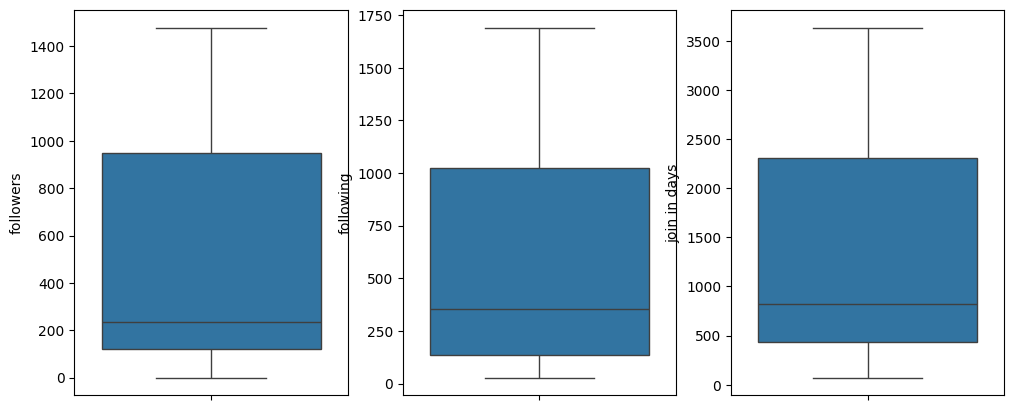

In [119]:
fig, ax = plt.subplots(1,3, figsize=[12,5])
sns.boxplot(merged_data['followers'], ax=ax[0])
sns.boxplot(merged_data['following'], ax=ax[1])
sns.boxplot(merged_data['join in days'], ax=ax[2])

<Axes: xlabel='following', ylabel='followers'>

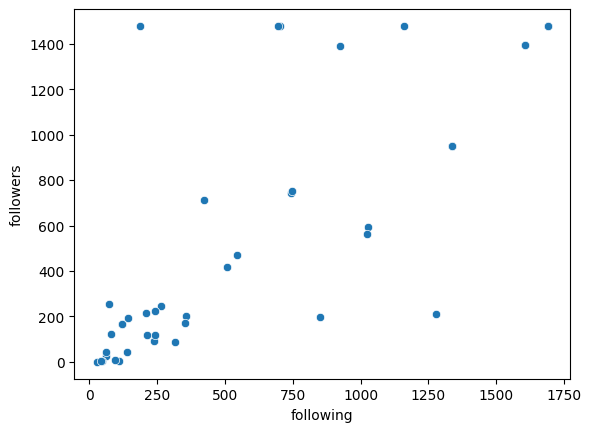

In [120]:
sns.scatterplot(merged_data, x='following', y='followers')

<Axes: xlabel='following', ylabel='join in days'>

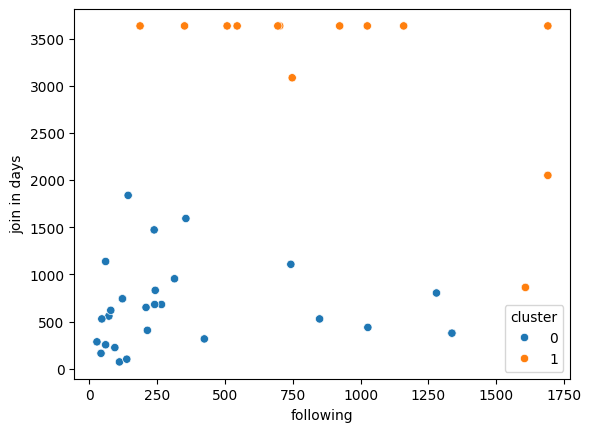

In [124]:
scaling = StandardScaler()
X= scaling.fit_transform(merged_data[['followers', 'join in days']])
km = KMeans(n_clusters=2) 
label = km.fit_transform(X)
label = np.argmax(label, axis=1)
merged_data['cluster'] = label

sns.scatterplot(merged_data, x='following', y='join in days', hue='cluster')

In [133]:
buzzer = [t.replace('@', '') for t in buzzer]

<Axes: xlabel='followers', ylabel='join in days'>

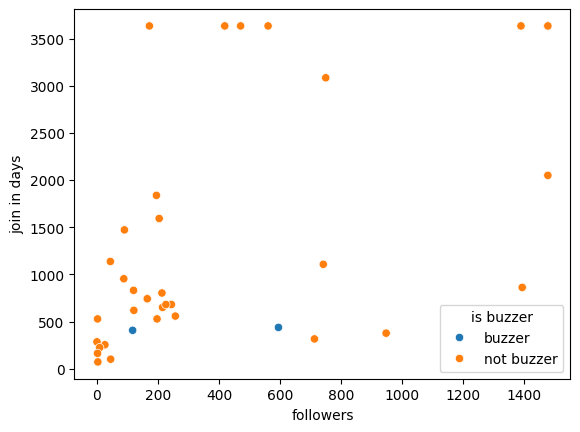

In [139]:
merged_data['is buzzer'] = np.where(merged_data['user_id'].isin(buzzer), 'buzzer', 'not buzzer')
sns.scatterplot(merged_data, x='followers', y='join in days', hue='is buzzer')

In [136]:
merged_data

,user_id,join,followers,following,description,feature,sentimen,negativity,join in days,cluster,is buzzer
0,AbdullahArdhi,2023-04-01,117.000,214.00,Slawi,kolaborasi ikn acwa power sinergi kehidupan hi...,negatif,0.998675,407.00,0,buzzer
1,bewithyiu,2021-05-01,742.000,743.00,Rumah Singgah Eunoia secreto.site/agno21,uang pajak dialokasikan berguna bangun patung ...,negatif,0.998542,1107.00,0,not buzzer
2,wientaxa,2024-03-01,3.000,111.00,Indonesia Bagian Marjinal,ikn sekedar perwujudan ambisi politik nafsu me...,negatif,0.998881,72.00,0,not buzzer
3,wibungitis,2020-05-01,90.000,239.00,rentry.co/sai55,they 're building ikn like township kumparan m...,negatif,0.998115,1472.00,0,not buzzer
4,avocado_juice41,2023-09-01,26.000,60.00,,ikn menelan biaya yg fantastis udah gitu urgen...,negatif,0.998780,254.00,0,not buzzer
5,Baggiioooo,2020-01-01,204.000,356.00,Surganya Allah,mmnita korut untk mngebom ikn dgn nuklirnya,negatif,0.997015,1593.00,0,not buzzer
6,tanyarlfes,2013-04-01,1478.125,1690.75,Entertainment & RecreationIndonesias.id/tanyar...,automated tanyarl sender kepooo tau pandangan ...,negatif,0.995690,3634.75,1,not buzzer
7,sinceApril1970,2023-05-01,948.000,1337.00,,and didn t brucey first spot the talent that i...,negatif,0.998793,377.00,0,not buzzer
8,sweetnaviblue,2022-07-01,244.000,266.00,in your heart,maen ikn,positif,0.309914,681.00,0,not buzzer
9,almema_hasnaa,2023-08-01,0.000,28.00,,dukungan ikn masyarakat indonesia memiliki sem...,positif,0.000143,285.00,0,not buzzer
